# Twitter Spam Classification 

### Importing necessary libraries for Exploratory Data Analysis and Model Building

In [83]:

import pandas as pd
import collections
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import math
import nltk

np.set_printoptions(suppress=True)

%matplotlib inline

In [84]:
from sklearn.metrics import confusion_matrix

### Importing and preparing data

In [85]:
#df_input_prefiltered -> complete dataset with labels
#df_input             -> dataset spam input


df_input = pd.read_csv('train.csv')


#updating column names to join dataframes on keys
df_input.columns = ['Id','tweet','following','followers','actions','is_retweet','location','type']

#dataframe merge and assign corresponding label


### Splitting tabular Data based on Spam/ Quality label

In [86]:
Quality_df = df_input[df_input.type == "Quality"]
spam_df = df_input[df_input.type == "Spam"]

Quality_df = Quality_df.sample(len(spam_df))
df = pd.concat([Quality_df,spam_df])

In [87]:
print("Number of Spam tweets:",len(spam_df),"\n")
print("Number of Ham tweets:",len(Quality_df))

Number of Spam tweets: 5815 

Number of Ham tweets: 5815


### Exploring existance of null values 

#### We observe that many features have null values, which need to be removed from the dataset 

In [88]:
df_input.isnull().sum()

Id               0
tweet            0
following      145
followers       16
actions       2773
is_retweet       1
location      1651
type             0
dtype: int64

### Removing unnecessary labels

In [89]:

print("\nNumber of tweets with null locations:",df_input.location.isnull().sum(),"\nHence, we remove this feature.")





del df_input['location']






Number of tweets with null locations: 1651 
Hence, we remove this feature.


## Extracting Features

has_hashtag is a binary variable. If the tweet was posted along with a hashtag, has_hastag = 1, else 0
num_hashtag is a continous variable. If takes the value corresponding to number of hashtags included in a tweet.

In [90]:
import re

has_hashtags = []

for i in df.tweet:
    if re.search('#',i):
        has_hashtags.append(1)

    else:
        has_hashtags.append(0)


df['has_hashtags'] = has_hashtags



has_media is a binary variable. If the tweet was posted along with a media link, has_media = 1, else 0

In [91]:
has_media = []

for i in df.tweet:
    if re.search('@',i):
        has_media.append(1)
    else:
        has_media.append(0)

df['has_media'] = has_media

has_urls is a binary variable. If the tweet consists a url link, has_url = 1, else 0

In [92]:
has_urls = []

for i in df.tweet:
    if re.search('https',i):
        has_urls.append(1)
    else:
        has_urls.append(0)

df['has_urls'] = has_urls

### f_ratio: The ratio of followers to following of a person, which is important in analysis Spam/ Ham tweets

In [93]:
df['f_ratio'] = (df['followers']+1)/(df['following']+1 )

### length is a continuous variable, corresponding to number of words in a given tweet

In [94]:
length = []
for i in range(0,len(df)):
    length.append(len(df.iloc[i].tweet))
df['length'] = length

###  DIGITS is a continuous variable, corresponds to number of digits in a given tweet

In [95]:
digits_list = []

for i in range(0,len(df)):
    if(sum(c.isdigit() for c in df.tweet.iloc[i]) == 0):
        digits_list.append(0)
    else:
        digits_list.append(sum(c.isdigit() for c in df.tweet.iloc[i]))

digits_col = pd.Series(digits_list)
df['DIGITS'] = digits_col.values

### CAP is a continuous variable, coreesponds to number of capitalized words in a given tweet.

In [96]:
cap_list = []

for i in range(0,len(df)):
    words = df.tweet.iloc[i].split()
    count = 0
    for j in range(0,len(words)):
        if(words[j].isupper()):
            count = count + 1;
    cap_list.append(count)    
    #print(cap_list)
        
cap_col = pd.Series(cap_list)
df['CAP'] = cap_col.values

## Exploratory Data Analysis 

### First, we  take a look at the difference between the tweets corresponding to Spam & Ham. We create new feaures called filtered_text and filtered_text_lower. 

### filtered_text contains the text of every corresponding tweet, filtered by the nltk stopwords.

### filtered_text_lower contains tokens after converting the filtered_text to lower case

In [97]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
filtered_text = []

for i in range(0,len(df)):
    word_list = str(df.tweet.iloc[i]).split()
    filtered_words = [word for word in word_list if word not in stopwords.words('english')]
    filtered_text.append(' '.join(filtered_words))
df['filtered_text'] = filtered_text
df['filtered_text_lower'] = df['filtered_text'].str.lower()

[nltk_data] Error loading stopwords: <urlopen error [WinError 10060] A
[nltk_data]     connection attempt failed because the connected party
[nltk_data]     did not properly respond after a period of time, or
[nltk_data]     established connection failed because connected host
[nltk_data]     has failed to respond>


In [98]:
df.columns

Index(['Id', 'tweet', 'following', 'followers', 'actions', 'is_retweet',
       'location', 'type', 'has_hashtags', 'has_media', 'has_urls', 'f_ratio',
       'length', 'DIGITS', 'CAP', 'filtered_text', 'filtered_text_lower'],
      dtype='object')

### Word Frequencies 

In [99]:
spam_text = []
spam_df = df[df.type=='Spam']

for i in range(0,len(spam_df)):
    spam_text.append(spam_df.filtered_text.iloc[i])
    
Quality_text = []
Quality_df = df[df.type=='Quality']

for i in range(0,len(Quality_df)):
    Quality_text.append(Quality_df.filtered_text.iloc[i])


Below is the plot of 50 most commonly used words in SPAM comment


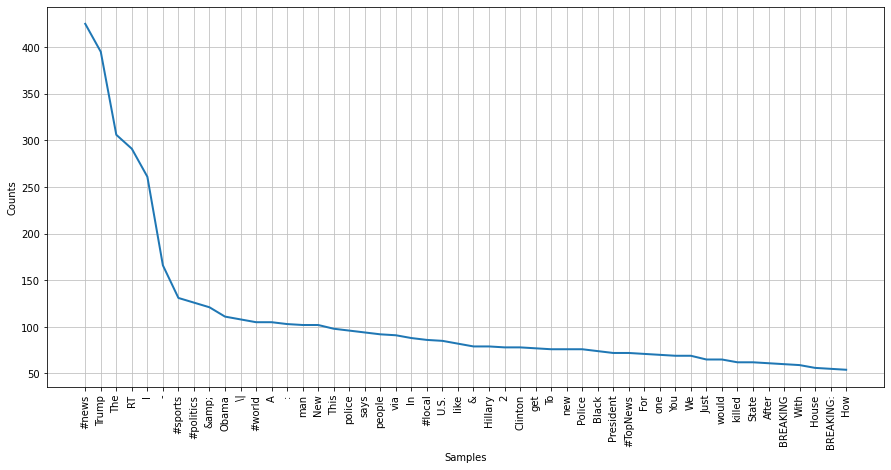


Below is the plot of 50 most commonly used words in Quality comment


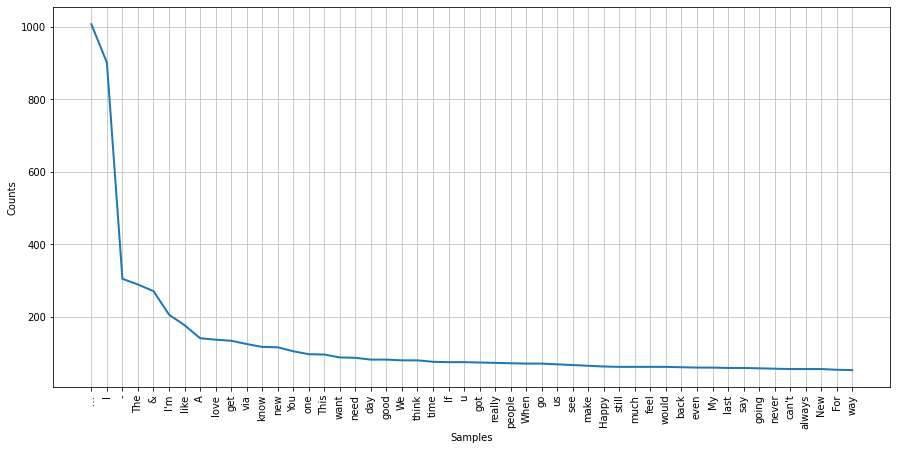

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [100]:
spam_text = ' '.join(spam_text).split()
freq = nltk.FreqDist(spam_text)

print("\nBelow is the plot of 50 most commonly used words in SPAM comment")
plt.figure(figsize=(15,7))
freq.most_common(50)
freq.plot(50)

Quality_text = ' '.join(Quality_text).split()
freq = nltk.FreqDist(Quality_text)
print("\nBelow is the plot of 50 most commonly used words in Quality comment")

plt.figure(figsize=(15,7))
freq.most_common(50)
freq.plot(50)

### Function to return ngram words 

from itertools import combinations
from collections import Counter

def ngram(lines,i):
    pair_counter = Counter()
    for line in lines:
        unique_tokens = sorted(set(line))  
        combos = combinations(unique_tokens, i)
        pair_counter += Counter(combos)
    return pair_counter

In [101]:
from itertools import combinations
from collections import Counter
def ngram(lines,i):
    pair_counter = Counter()
    for line in lines:
        unique_tokens = sorted(set(line))
        combos = combinations(unique_tokens, i)
        pair_counter += Counter(combos)
        return pair_counter

### Applying 1-gram, bi-gram and tri-gram models on Spam corpus 

In [102]:
lines = []
for i in range(0,len(spam_df)):
    tokens = spam_df.filtered_text_lower.iloc[i].split()
    lines.append(tokens)
    one_gram_spam = ngram(lines,1)
    bi_gram_spam = ngram(lines,2)
    tri_gram_spam = ngram(lines,3)

spam_df = df[df.label==1]
ham_df = df[df.label==0]

lines = []
for i in range(0,len(spam_df)):
    tokens = spam_df.filtered_text_lower.iloc[i].split()
    lines.append(tokens)

one_gram_spam = ngram(lines,1)
bi_gram_spam = ngram(lines,2)
tri_gram_spam = ngram(lines,3)

### Applying 1-gram, bi-gram and tri-gram models on Ham corpus 

In [103]:
lines = []
for i in range(0,len(Quality_df)):
    tokens = Quality_df.filtered_text_lower.iloc[i].split()
    lines.append(tokens)
one_gram_Quality = ngram(lines,1)
bi_gram_Quality = ngram(lines,2)
tri_gram_Quality = ngram(lines,3)

lines = []
for i in range(0,len(ham_df)):
    tokens = ham_df.filtered_text_lower.iloc[i].split()
    lines.append(tokens)
    
one_gram_ham = ngram(lines,1)
bi_gram_ham = ngram(lines,2)
tri_gram_ham = ngram(lines,3)

### Top 25 word occurances in Spam tweets (1-gram, bi-gram & tri-gram models)

In [104]:
one_gram_spam.most_common(20)
bi_gram_spam.most_common(20)
tri_gram_spam.most_common(20)

[(('#jan', 'chelsea', 'diagnoses'), 1),
 (('#jan', 'chelsea', 'disease'), 1),
 (('#jan', 'chelsea', 'handler'), 1),
 (('#jan', 'chelsea', 'https://t.co/drn35xtsjz'), 1),
 (('#jan', 'chelsea', 'https://t.co/k8prqcwtri'), 1),
 (('#jan', 'chelsea', 'idiot'), 1),
 (('#jan', 'chelsea', 'trump'), 1),
 (('#jan', 'chelsea', 'with'), 1),
 (('#jan', 'diagnoses', 'disease'), 1),
 (('#jan', 'diagnoses', 'handler'), 1),
 (('#jan', 'diagnoses', 'https://t.co/drn35xtsjz'), 1),
 (('#jan', 'diagnoses', 'https://t.co/k8prqcwtri'), 1),
 (('#jan', 'diagnoses', 'idiot'), 1),
 (('#jan', 'diagnoses', 'trump'), 1),
 (('#jan', 'diagnoses', 'with'), 1),
 (('#jan', 'disease', 'handler'), 1),
 (('#jan', 'disease', 'https://t.co/drn35xtsjz'), 1),
 (('#jan', 'disease', 'https://t.co/k8prqcwtri'), 1),
 (('#jan', 'disease', 'idiot'), 1),
 (('#jan', 'disease', 'trump'), 1)]

### Top 25 word occurances in Quality tweets (1-gram, bi-gram & tri-gram models)

In [105]:
one_gram_Quality.most_common(20)
bi_gram_Quality.most_common(20)
tri_gram_Quality.most_common(20)

[(('happypic.twitter.com/2xz5ez9gk1', 'makes', 'me'), 1),
 (('happypic.twitter.com/2xz5ez9gk1', 'makes', 'picture'), 1),
 (('happypic.twitter.com/2xz5ez9gk1', 'makes', 'so'), 1),
 (('happypic.twitter.com/2xz5ez9gk1', 'makes', 'this'), 1),
 (('happypic.twitter.com/2xz5ez9gk1', 'me', 'picture'), 1),
 (('happypic.twitter.com/2xz5ez9gk1', 'me', 'so'), 1),
 (('happypic.twitter.com/2xz5ez9gk1', 'me', 'this'), 1),
 (('happypic.twitter.com/2xz5ez9gk1', 'picture', 'so'), 1),
 (('happypic.twitter.com/2xz5ez9gk1', 'picture', 'this'), 1),
 (('happypic.twitter.com/2xz5ez9gk1', 'so', 'this'), 1),
 (('makes', 'me', 'picture'), 1),
 (('makes', 'me', 'so'), 1),
 (('makes', 'me', 'this'), 1),
 (('makes', 'picture', 'so'), 1),
 (('makes', 'picture', 'this'), 1),
 (('makes', 'so', 'this'), 1),
 (('me', 'picture', 'so'), 1),
 (('me', 'picture', 'this'), 1),
 (('me', 'so', 'this'), 1),
 (('picture', 'so', 'this'), 1)]

### We conduct a series of hypothesis tests we include features which show statistical significance between Qulaity and Spam classes

In [106]:
df = df[['label','has_hashtags', 'num_hashtags', 'has_media','user_favourites_count',
       'has_urls', 'has_favorite_count', 'has_place', 'has_retweet_count',
       'is_RT', 'has_user_description', 'has_user_followers_count',
       'has_user_listed_count', 'has_user_name', 'is_user_verfied', 'f_ratio',
       'length', 'DIGITS', 'CAP', 'filtered_text', 'filtered_text_lower','user_listed_count']]

KeyError: "['label', 'num_hashtags', 'user_favourites_count', 'has_favorite_count', 'has_place', 'has_retweet_count', 'is_RT', 'has_user_description', 'has_user_followers_count', 'has_user_listed_count', 'has_user_name', 'is_user_verfied', 'user_listed_count'] not in index"

## We plot distribution plots for continuous variables 

### Distribution plot for number of digits that occured in a tweet, based on Spam/ Ham label

In [ ]:
plt.figure(figsize=(10,7))
sns.distplot(df[df.is_spam==0].DIGITS,color="black",kde=True,label="Quality");
sns.distplot(df[df.is_spam==1].DIGITS,color="red",kde=True,label="Spam");
plt.xlim(0,20)

large = 24

plt.rc('legend',fontsize=large)
plt.rc('axes',titlesize = 20)
plt.rc('axes',labelsize = 16)
plt.rc('xtick',labelsize = 20)
plt.rc('ytick',labelsize = 20)



plt.title("KDE distribution plot\nNumber of digits in Quality and Spam\n")
plt.xlabel("Number of digits")
plt.ylabel("Probability")
plt.show()

plt.show()

### Distribution plot for number of capitalized words that occured in a tweet, based on Spam/ Ham label 

In [ ]:
plt.figure(figsize=(12,7))
sns.distplot(df[df.is_spam==0].CAP,color="black",kde=True)
sns.distplot(df[df.is_spam==1].CAP,color="red",kde=True)
plt.xlim(0,10)

large = 24

plt.rc('legend',fontsize=large)
plt.rc('axes',titlesize = 20)
plt.rc('axes',labelsize = 16)
plt.rc('xtick',labelsize = 20)
plt.rc('ytick',labelsize = 20)



plt.title("KDE distribution plot\nNumber of Capitalized words in Ham and Spam\n")
plt.xlabel("Number of Capitalized words")
plt.ylabel("Probability")
plt.show()

plt.show()

plt.show()

### Distribution plot of Length of tweets, based on the Spam or Ham label 

In [ ]:
plt.figure(figsize=(18,9))
sns.distplot(df[df.is_spam==0].length,color="black",kde=True)
sns.distplot(df[df.is_spam==1].length,color="red",kde=True)
plt.show()

In [ ]:
cols = [ 'DIGITS', 'CAP']

for i in range(1,len(cols)):
    plt.figure(figsize=(12,8))
    c = cols[i]
    print("Count plot for","'",cols[i],"' feature, based on Spam/ Ham tweet label")
    sns.countplot(c,hue=df.is_spam,data=df)
    plt.show()
    print("\n")

In [ ]:
def comfusion_matrix_properties(mat):


    from sklearn.metrics import confusion_matrix

    mat = confusion_matrix(y_test,ypred)
    print("Confusion Matrix:\n\n",mat,"\n")

    TP = mat[0][0]
    FP = mat[0][1]
    FN = mat[1][0]
    TN = mat[1][1]


    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    print("True Positive Rate",round(TPR*100,2),"%")

    # Specificity or true negative rate
    TNR = TN/(TN+FP)
    print("True Negative Rate",round(TNR*100,2),"%")

    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    print("Positive Predictive Value",round(PPV*100,2),"%")

    # Negative predictive value
    NPV = TN/(TN+FN)
    print("Negative Predictive Value",round(NPV*100,2),"%")

    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    print("False Positive Rate",round(FPR*100,2),"%")

    # False negative rate
    FNR = FN/(TP+FN)
    print("False Negative Rate",round(FNR*100,2),"%")

    # False discovery rate
    FDR = FP/(TP+FP)
    print("False Discovery Rate",round(FDR*100,2),"%")


    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    print("Overall Accuracy",round(ACC*100,2),"%")

# Modelling & Evaluation

## As a base model, we run a Naive Bayes classifier, purely based on tweet text.

In [ ]:
NB_df = df[['filtered_text','type']]
NB_df = NB_df.sample(frac=1)

from sklearn.feature_extraction.text import CountVectorizer

vecfinal = CountVectorizer(min_df=50,max_df=0.8,stop_words="english")
finalX = vecfinal.fit_transform(NB_df['filtered_text'])

### Splitting into training and testing data 

In [ ]:
split_limit = round(len(NB_df)/2)
X_train = finalX.toarray()[:split_limit]
X_test = finalX.toarray()[split_limit:]
y_train = NB_df.type[:split_limit]
y_test = NB_df.type[split_limit:]

###  Applying Bernoulli Naive Bayes Model

In [118]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import f1_score

clf_nb = BernoulliNB()
clf_nb.fit(X_train, y_train)
ypred = clf_nb.predict(X_test)
ypred_NB_model=clf_nb.predict(X_test)
accuracy = f1_score(y_test, ypred, average='weighted')
print("Accuracy for this model: ", accuracy*100,"%")

Accuracy for this model:  72.3586296196302 %


In [ ]:
print("Naive Bayes Model ")
mat = confusion_matrix(y_test,ypred)
comfusion_matrix_properties(mat)

## Now, we would like to see how the non-text based features work for prediction 

## We subset only necessary features which make sense in this scenario, i.e., features that statistically differentiate between spam and ham tweets.

In [110]:
y = df.type
X = df[['has_hashtags',  'has_media',
       'has_urls',

       'length', 'DIGITS', 'CAP',]]
model = X

### Prediction using Decision Tree Classifier

In [111]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(model, y, test_size = 0.5,random_state=0)

depth = []
training_score = []
testing_score = []

for i in range(1,25):
    clf_dt = DecisionTreeClassifier(criterion = "gini",random_state=0)
    clf_dt.max_depth = i
    clf_dt.fit(X_train, y_train)
    pred_train = clf_dt.predict(X_train)
    #print("Training accuracy, with",i,"depth :",accuracy_score(pred_train,y_train)*100)

    pred_test = clf_dt.predict(X_test)
    #print("Testing accuracy, with",i,"depth :",accuracy_score(pred_test,y_test)*100,"\n")

    depth.append(i)
    training_score.append(accuracy_score(pred_train,y_train))
    testing_score.append(accuracy_score(pred_test,y_test))

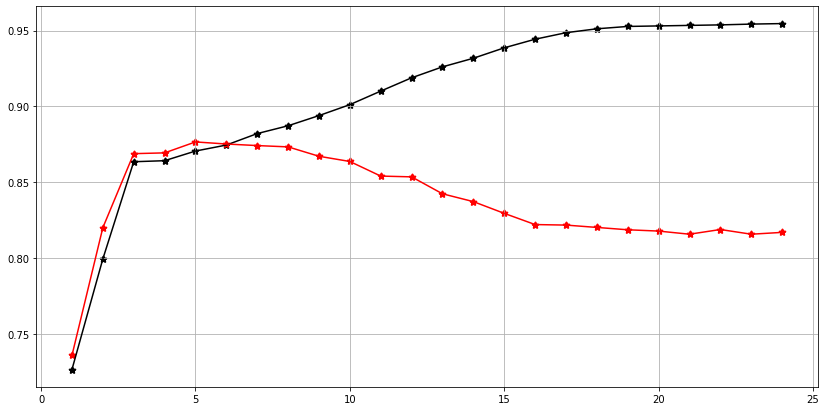

In [112]:
plt.figure(figsize=(14,7))
plt.grid()

plt.plot(depth, training_score,c='black')
plt.plot(depth, testing_score,c='red')
plt.scatter(depth, training_score,c='black',marker='*',linewidth=2)
plt.scatter(depth, testing_score,c='red',marker='*',linewidth=2)

In [114]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

X = model

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5,random_state=0)

clf = DecisionTreeClassifier(random_state=0)

param_grid = {
              "criterion": ["gini", "entropy"],
              "max_depth": list(np.arange(1,50,1)),
              }

CLF = GridSearchCV(estimator = clf, param_grid=param_grid, cv = 5)
CLF.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28, 29, 30, ...]})

In [115]:
CLF.best_params_

{'criterion': 'entropy', 'max_depth': 6}

In [116]:
clf_dt = DecisionTreeClassifier(criterion=CLF.best_params_['criterion'],max_depth=CLF.best_params_['max_depth'],random_state=0)
clf_dt.fit(X_train,y_train)
ypred = clf_dt.predict(X_test)
ypred_DT_model=clf_dt.predict(X_test)
print("Prediction Accuracy:",accuracy_score(ypred,y_test)*100,"%")

Prediction Accuracy: 87.68701633705933 %
